In [1]:
import csv
import re
import datetime
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def read_csv_data(file_path):
    # Create an empty list to store the data
    data = []

    # Open the CSV file
    with open(file_path, 'r') as file:
        # Create a CSV reader object
        reader = csv.reader(file)
        
        # Skip the header row if it exists
        next(reader)
        
        # Iterate over each row in the CSV file
        for row in reader:
            # Extract the sentence and sentiment from the row
            sentence = row[0]
            sentiment = row[1]
            
            # Create a dictionary to store the sentence and sentiment
            entry = {'sentence': sentence, 'sentiment': sentiment}
            
            # Append the entry to the data list
            data.append(entry)

    # Return the data list
    return data

In [2]:

# Import data
data = read_csv_data('.data/data.csv')

# Prepare the dataset
sentences = [d['sentence'] for d in data]
sentiments = [2 if d['sentiment'] == 'positive' else (1 if d['sentiment'] == 'neutral' else 0) for d in data]
# Convert the sentiments list to a NumPy array as this is the format Keras requires
sentiments = np.array(sentiments)


In [3]:
print(sentences[0:2])

["The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .", '$ESI on lows, down $1.50 to $2.50 BK a real possibility']


In [4]:
print(sentiments[0:2])

[2 0]


In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenize the dataset
max_words = 5000
max_len = 50
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>', lower=True, filters='!"#&()*+,-./:;<=>?@[\\]\'^_`{|}~\t\n')
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, padding='post', truncating='post', maxlen=max_len)

In [6]:
# Print the first sentence and its padded sequence
print(sentences[0])
print(padded_sequences[0])
print(tokenizer.sequences_to_texts([padded_sequences[0]]))
print(type(padded_sequences), padded_sequences.shape)
print(type(sentiments), len(sentiments))


The GeoSolutions technology will leverage Benefon 's GPS solutions by providing Location Based Search Technology , a Communities Platform , location relevant multimedia content and a new and powerful commercial model .
[   2 3968  135   14 3127 1407   10 2277  134   19  823 1221  101 2278
  135    7 3128 1222 1221 2010 3129  682    6    7   59    6 3969  581
  473    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]
['the geosolutions technology will leverage benefon s gps solutions by providing location based search technology a communities platform location relevant multimedia content and a new and powerful commercial model <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>']
<class 'numpy.ndarray'> (5842, 50)
<class 'numpy.ndarray'> 5842


In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
training_sentences, validation_sentences, training_sentiments, validation_sentiments = train_test_split(padded_sequences, sentiments, test_size=0.2, random_state=42)

print("Training dataset:", "sentences -", training_sentences.shape, "sentiments -", training_sentiments.shape)
print("Validation dataset:", "sentences -", validation_sentences.shape, "sentiments -", validation_sentiments.shape)


Training dataset: sentences - (4673, 50) sentiments - (4673,)
Validation dataset: sentences - (1169, 50) sentiments - (1169,)


In [8]:
# Build a classification model using a neural network

# Define identifiable information
model_name = 'model-nn'
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
batch_size = 16
embedding_dim = 4

# Create the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    Embedding(max_words, embedding_dim, input_shape=(max_len,)),
    GlobalAveragePooling1D(),
    Dropout(0.2),
    Dense(3, activation='softmax')
])

# Define a lower learning rate
learning_rate = 0.001

# Create an Adam optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

# Compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

/Users/pedroleitao/.pyenv/versions/3.9.18/envs/tf/lib/python3.9/site-packages/keras/src/layers/core/embedding.py:81: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2024-04-08 10:16:06.553359: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-08 10:16:06.553373: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-08 10:16:06.553377: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-08 10:16:06.553393: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-08 10:16:06.553404: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow devic

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 4)          │        20,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 4)              │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │            15 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,015 (78.18 KB)

 Trainable params: 20,015 (78.18 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Create a log directory with the identifiable information
log_dir = f"logs/{model_name}/batchsize{batch_size}_{timestamp}_maxwords{max_words}_embedding{embedding_dim}"

# Set up the TensorBoard callback
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

from tensorflow.keras.callbacks import EarlyStopping

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(training_sentences, training_sentiments,
                    batch_size=batch_size,
                    epochs=200,
                    validation_data=(validation_sentences, validation_sentiments),
                    verbose=0, # Set to 1 to print the training log
                    callbacks=[tensorboard_callback,early_stopping_callback])

# Print training statistics
print("Training accuracy:", history.history['accuracy'][-1])
print("Validation accuracy:", history.history['val_accuracy'][-1])

2024-04-08 10:16:06.792729: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Training accuracy: 0.8365076184272766
Validation accuracy: 0.7100085616111755


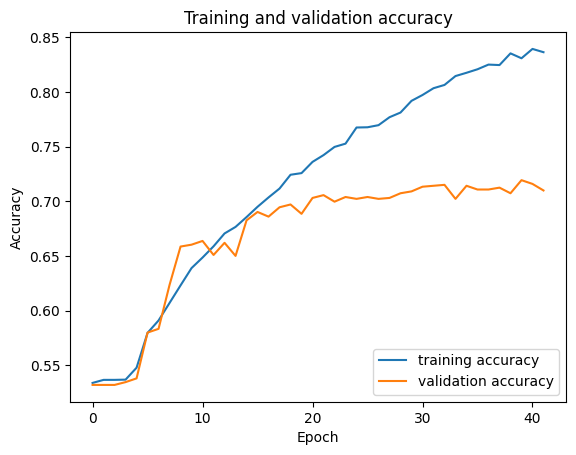

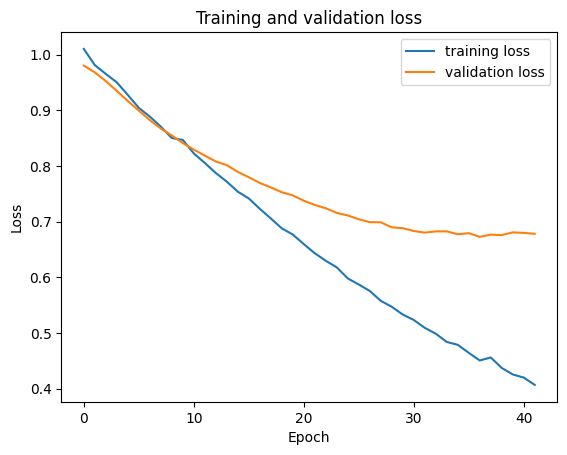

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [11]:
# Try a few predictions

# Define a function to predict the sentiment of a sentence
def predict_sentiment(sentence):
    # Tokenize the sentence
    sequence = tokenizer.texts_to_sequences([sentence])
    
    # Pad the sequence
    padded_sequence = pad_sequences(sequence, padding='post', truncating='post', maxlen=max_len)
    
    # Get the prediction
    prediction = model.predict(padded_sequence)[0]
    
    # Get the sentiment with the highest probability
    sentiment = np.argmax(prediction)
    
    return sentiment, prediction

# Predict the sentiment of a positive sentence
sentence = "IBM reported an increase in revenue during the last quarter"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
# Print the sentiment
if sentiment == 2:
    print("Correctly predicted - Sentiment: Positive")

# Predict the sentiment of a neutral sentence
sentence = "IBM is a technology company"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
if sentiment == 1:
    print("Correctly predicted - Sentiment: Neutral")

# Predict the sentiment of a negative sentence
sentence = "IBM down $3.4 in yesterday's trading session"
sentiment, predictions = predict_sentiment(sentence)
print(f"Sentence: {sentence}, Predictions: {predictions}")
if sentiment == 0:
    print("Correctly predicted - Sentiment: Negative")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


Sentence: IBM reported an increase in revenue during the last quarter, Predictions: [0.10793524 0.14154196 0.75052285]
Correctly predicted - Sentiment: Positive
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Sentence: IBM is a technology company, Predictions: [0.12592863 0.6510984  0.22297299]
Correctly predicted - Sentiment: Neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Sentence: IBM down $3.4 in yesterday's trading session, Predictions: [0.38864955 0.29330721 0.31804326]
Correctly predicted - Sentiment: Negative


[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.001s...
[t-SNE] Computed neighbors for 5000 samples in 0.023s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.051566


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.643921


[t-SNE] KL divergence after 300 iterations: 2.665655


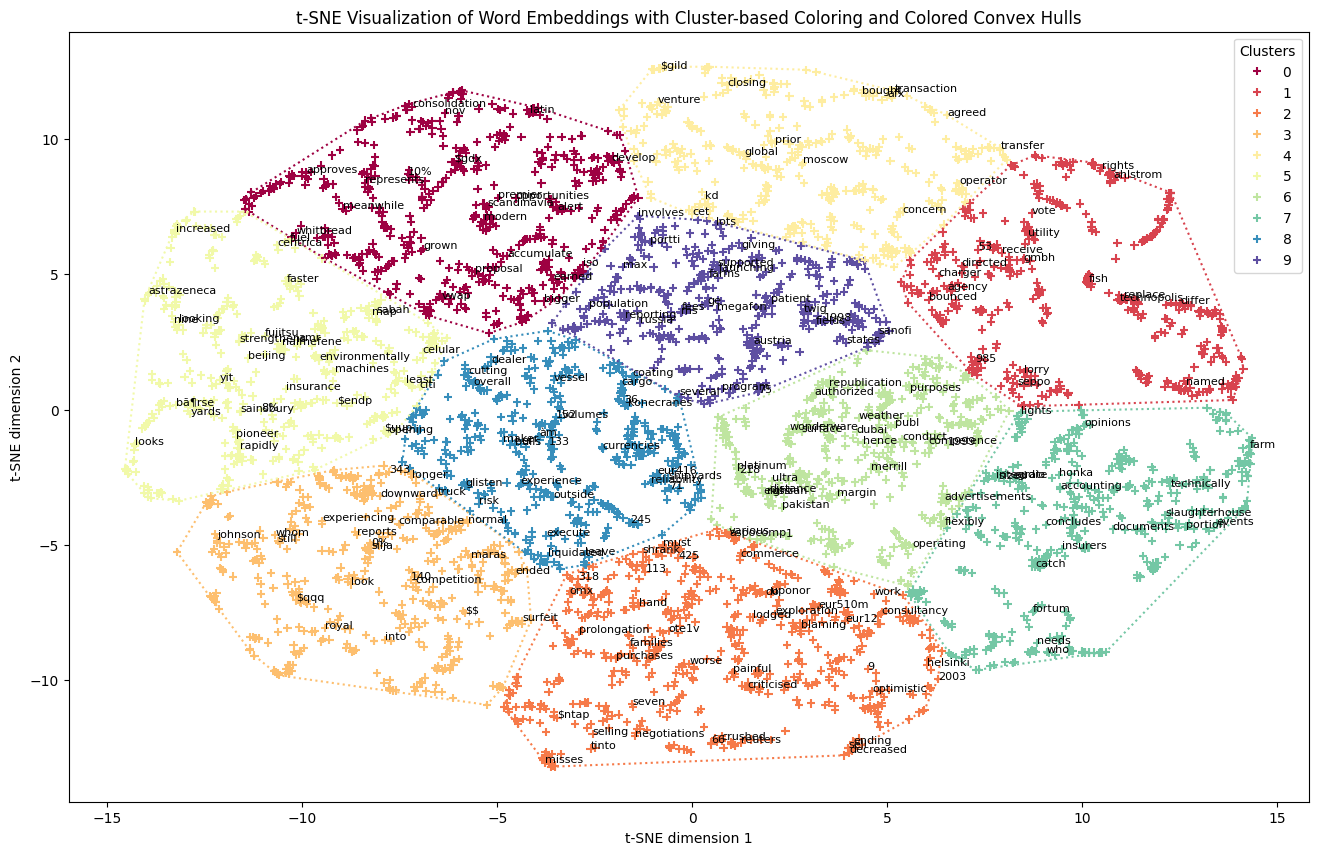

In [12]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
from scipy.spatial import ConvexHull
from matplotlib.colors import ListedColormap

# Assuming 'model' and 'tokenizer' are predefined
embeddings = model.layers[0].get_weights()[0]  # Accessing the weights of the first layer, which is the Embedding layer

# Use t-SNE to reduce the dimensionality of the embeddings
tsne = TSNE(n_components=2, verbose=1, perplexity=10, n_iter=300)
tsne_results = tsne.fit_transform(embeddings)

# Apply K-means clustering on the t-SNE results
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(tsne_results)

# Reverse mapping from index to word, adjusted to ensure it matches the embeddings size
num_embeddings = tsne_results.shape[0]
reverse_word_map = {index: word for word, index in tokenizer.word_index.items() if index < num_embeddings}

# Plotting with cluster-based coloring
plt.close('all')
plt.figure(figsize=(16, 10))
scatter = plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters, cmap='Spectral', marker="+")

# Generate a color map from the scatter plot colors
cmap = ListedColormap(scatter.cmap(scatter.norm(np.unique(clusters))))

# Annotate a subset of words to avoid clutter
for i in range(num_embeddings):  
    if i % 20 == 0:
        word = reverse_word_map.get(i)
        if word:
            safe_word = word.replace("$", "\$")
            plt.annotate(safe_word, (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8)

# Draw convex hulls with colors matching their clusters
for cluster in range(kmeans.n_clusters):
    # Find the points within this cluster
    points_in_cluster = tsne_results[clusters == cluster, :]
    if points_in_cluster.shape[0] < 3:
        # Convex hulls require at least 3 points
        continue
    hull = ConvexHull(points_in_cluster)
    for simplex in hull.simplices:
        plt.plot(points_in_cluster[simplex, 0], points_in_cluster[simplex, 1], linestyle=':', color=cmap.colors[cluster])

plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.title('t-SNE Visualization of Word Embeddings with Cluster-based Coloring and Colored Convex Hulls')

# Creating a legend for clusters
plt.legend(*scatter.legend_elements(), loc="best", title="Clusters")
plt.show()

